# Investigate each state's dynamics in clustered neural space


In [1]:
import os, pickle, copy, sys
os.chdir(os.path.expanduser(os.path.join("~", "Projects", "zimmer")))

import numpy as np
np.random.seed(1234)

In [2]:
# Plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.animation as manimation
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable

from hips.plotting.colormaps import gradient_cmap
from hips.plotting.sausage import sausage_plot
from hips.plotting.layout import create_axis_at_location

# Come up with a set of colors
import seaborn as sns
sns.set_style("white")
# sns.set_context("paper")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

%matplotlib inline

In [3]:
# Modeling stuff
import importlib
from sklearn.decomposition import PCA

from pybasicbayes.distributions import Gaussian, Regression, DiagonalRegression
from pybasicbayes.util.text import progprint_xrange
from pyhsmm.util.general import relabel_by_usage, relabel_by_permutation
from pyslds.util import get_empirical_ar_params

# Load basic pyslds models
from pyslds.models import HMMSLDS, WeakLimitStickyHDPHMMSLDS

# Load worm modeling specific stuff
import zimmer.io
importlib.reload(zimmer.io)
from zimmer.io import WormData, find_shared_neurons, load_key

import zimmer.states
importlib.reload(zimmer.states)

import zimmer.models
importlib.reload(zimmer.models)
from zimmer.models import HierarchicalWeakLimitStickyHDPHMMSLDS, HierarchicalRecurrentSLDS, HierarchicalRecurrentOnlySLDS
from zimmer.emissions import HierarchicalDiagonalRegression

import zimmer.plotting
importlib.reload(zimmer.plotting)
from zimmer.plotting import plot_1d_continuous_states, plot_3d_continuous_states, plot_vector_field_3d, \
    plot_discrete_state_samples, plot_changepoint_prs, make_states_3d_movie, plot_3d_dynamics, \
    make_states_dynamics_movie, plot_transition_matrix

from zimmer.util import states_to_changepoints

In [4]:
# IO
run_num = 1
results_dir = os.path.join("results", "cluster_activity", "run{:03d}".format(run_num))
assert os.path.exists(results_dir)

# Specify the signal to model
signal = "dff_deriv"

# Hyperparameters
Kmax = 15      # number of latent discrete states
D_latent = 3   # latent linear dynamics' dimension
D_in = 1       # number of input dimensions
D_obs = 60

alpha = 3.     # Transition matrix concentration
gamma = 3.0    # Base state concentration
kappa = 100.   # Stickiness parameter

alpha_0 = 1.0  # Gamma prior for emission variance
beta_0 = 1.0  # Gamma prior for emission variance

# Number of worms to fit
N_worms = 5

In [5]:
def cached(results_name):
    def _cache(func):
        def func_wrapper(*args, **kwargs):
            results_file = os.path.join(results_dir, results_name)
            if not results_file.endswith(".pkl"):
                results_file += ".pkl"

            if os.path.exists(results_file):
                with open(results_file, "rb") as f:
                    results = pickle.load(f)
            else:
                assert os.path.exists(results_dir)
                results = func(*args, **kwargs)
                with open(results_file, "wb") as f:
                    pickle.dump(results, f)

            return results
        return func_wrapper
    return _cache

# Load the data

In [6]:
# Load the data
worm_datas = [WormData(i, name="worm{}".format(i)) for i in range(N_worms)]
Ns = np.array([wd.N for wd in worm_datas])
Ts = np.array([wd.T for wd in worm_datas])
Ys = [getattr(wd, signal) for wd in worm_datas]

if signal == "dff_deriv":
    Ys = [Y * 10 for Y in Ys]

# Get the "true" discrete states as labeled by Zimmer
z_trues = [wd.zimmer_states for wd in worm_datas]
perm_z_trues, newlabels = relabel_by_usage(z_trues, return_mapping=True)
z_trues = perm_z_trues

# Get the key
z_key = load_key()
perm_z_key = [z_key[i] for i in np.argsort(newlabels)]
z_key = perm_z_key

# Get the names of the neurons
all_neuron_names = np.unique(np.concatenate([wd.neuron_names for wd in worm_datas]))
N_neurons = all_neuron_names.size
print("{} neurons across all {} worms".format(N_neurons, N_worms))

# Find the shared neurons
shared_neurons = find_shared_neurons(worm_datas)
print("{} shared neurons".format(len(shared_neurons)))
Ys_shared = []
for wd, Y in zip(worm_datas, Ys):
    shared_indices = wd.find_neuron_indices(shared_neurons)
    Ys_shared.append(Y[:, shared_indices])

# Construct a big dataset with all neurons for each worm
datasets = []
data_masks = []
for wd in worm_datas:
    this_dataset = np.zeros((wd.T, N_neurons))
    this_mask = np.zeros((wd.T, N_neurons), dtype=bool)
    indices = wd.find_neuron_indices(all_neuron_names)
    for n, index in enumerate(indices):
        if index is not None:
            this_dataset[:,n] = getattr(wd, signal)[:, index]
            this_mask[:,n] = True

    datasets.append(this_dataset)
    data_masks.append(this_mask)

477 neurons across all 5 worms
Potentially shared neurons:
 ['---' 'AIBL' 'AIBR' 'ALA' 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVER' 'RIBL' 'RID'
 'RIML' 'RIMR' 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB01' 'VB02']
Found 15 truly shared neurons:
['AIBL', 'AIBR', 'ALA', 'AVAL', 'AVAR', 'AVBL', 'AVER', 'RID', 'RIML', 'RIMR', 'RMED', 'RMEL', 'RMER', 'VB01', 'VB02']
15 shared neurons


# Initialize latent states with PCA

90% variance explained:  9
3 PCs capture:  0.697690087237
90% variance explained:  9
3 PCs capture:  0.696392879184
90% variance explained:  15
3 PCs capture:  0.591258088141
90% variance explained:  15
3 PCs capture:  0.654669233579
90% variance explained:  13
3 PCs capture:  0.532089042023


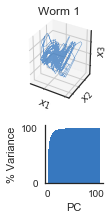

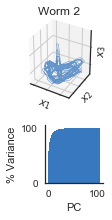

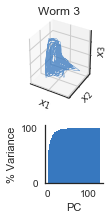

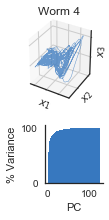

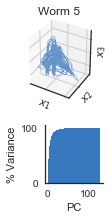

In [7]:
def plot_pca_trajectories(worm, Y):
    # Try to reproduce their plot of PC's over time
    n_comps = Y.shape[1]
    pca = PCA(n_components=n_comps, whiten=True)
    pca.fit(Y)

    x_pca = pca.transform(Y)

    fig = plt.figure(figsize=(1.5,3.))
    ax = create_axis_at_location(fig, 0.2, 1.5, 1.1, 1.25, projection="3d")
    ax.plot(x_pca[:,0], x_pca[:,1], x_pca[:,2], lw=0.5, alpha=0.75, ls='-', color=colors[0])
    ax.set_xlabel("$x_1$", labelpad=-12)
    ax.set_ylabel("$x_2$", labelpad=-12)
    ax.set_zlabel("$x_3$", labelpad=-12)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_title("Worm {}".format(worm+1))

    # Plot percent variance explained
    ax = create_axis_at_location(fig, .55, 0.4, .8, .8, box=False)
    ax.patch.set_alpha(0.0)
    ax.bar(np.arange(n_comps),  100 * np.cumsum(pca.explained_variance_ratio_), width=1, color=colors[0])
#     ax.plot(np.arange(n_comps), 90 * np.ones(n_comps), ':r')
    ax.set_xlabel("PC")
    ax.set_ylabel("% Variance")

    print("90% variance explained: ", np.where(np.cumsum(pca.explained_variance_ratio_) > .90)[0][0])
    print("3 PCs capture: ", np.sum(pca.explained_variance_ratio_[:3]))
#     plt.savefig(os.path.join(results_dir, "pca_trajectory_worm{}.pdf".format(worm)))
    
#     plt.figure()
#     plt.hist2d(x_pca[:,0], x_pca[:,1], np.linspace(-3, 3, 25))

# Plot PCA trajectories for first worm
for i in range(N_worms):
    plot_pca_trajectories(i, Ys[i])

In [8]:
@cached("pca")
def fit_pca(Ys_shared):
    # Try to reproduce their plot of PC's over time
    pca = PCA(n_components=D_latent, whiten=True)
    pca.fit(np.vstack(Ys_shared))

    x_inits = [pca.transform(Y) for Y in Ys_shared]
    C_init = pca.components_.T
    return x_inits, C_init


# Fit PCA and plot the latent states
x_inits, C_init = fit_pca(Ys_shared)


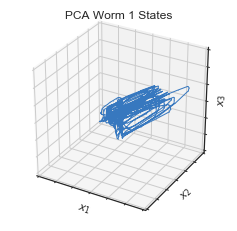

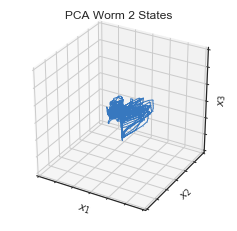

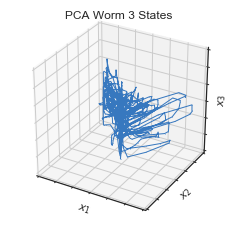

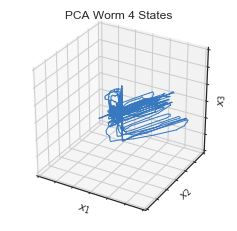

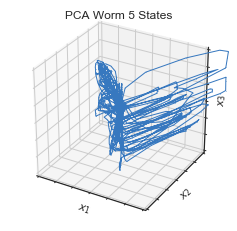

In [9]:
for worm in range(N_worms):
    plot_3d_continuous_states(x_inits[worm], np.zeros(Ts[worm], dtype=np.int32), colors,
                              figsize=(4, 4),
                              title="PCA Worm {} States".format(worm + 1),
                              results_dir=results_dir,
                              filename=None,
                              lw=1,
                              lim=6)

# Fit some models

In [10]:
def make_slds_parameters():
    init_dynamics_distns = [
        Gaussian(
            mu=np.zeros(D_latent),
            sigma=3*np.eye(D_latent),
            nu_0=D_latent + 2, sigma_0=3. * np.eye(D_latent),
            mu_0=np.zeros(D_latent), kappa_0=1.0,
        )
        for _ in range(Kmax)]

    # dynamics_hypparams = get_empirical_ar_params(
    #     [np.hstack((np.vstack(pca_trajs)[:,:P], np.ones((sum(Ts), 1))))],
    #     dynamics_hypparams)

    As = [np.hstack((0.99 * np.eye(D_latent), np.zeros((D_latent, D_in)))) for _ in range(Kmax)]
    dynamics_distns = [
        Regression(
            A=As[k],
            sigma=np.eye(D_latent),
            nu_0=D_latent + D_in + 2,
            S_0=np.eye(D_latent),
            M_0=np.hstack((np.eye(D_latent), np.zeros((D_latent, D_in)))),
            K_0=np.eye(D_latent + D_in),
        )
        for k in range(Kmax)]

    emission_distns = \
        DiagonalRegression(
            D_obs, D_latent + D_in,
            alpha_0=alpha_0, beta_0=beta_0)

    return init_dynamics_distns, dynamics_distns, emission_distns

# Fit standard LDS models

In [11]:
def _fit_lds(x_inits, ys, masks, N_gibbs=500):
    print("Fitting standard LDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_slds_parameters()
        
    x_inits = [None] * len(ys) if x_inits is None else x_inits
    
    # LDS is a switching LDS with one state
    lds = HMMSLDS(
        init_dynamics_distns=init_dynamics_distns[:1],
        dynamics_distns=dynamics_distns[:1],
        emission_distns=emission_distns,
        alpha=alpha,
        init_state_distn='uniform')
    
    # Add the data
    for y, mask, xi in zip(ys, masks, x_inits):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        lds.add_data(data=y, mask=mask, inputs=inputs)

        # Initialize continuous latent states
        if xi is not None:
            lds.states_list[-1].gaussian_states = xi[:, :D_latent]

    # Resample parameters once to be consistent with x_init
    lds.resample_parameters()
    
    # Fit the model with MCMC
    def evaluate(model):
        ll = model.log_likelihood()
        return ll

    def update_gibbs(model):
        model.resample_model()
        return evaluate(model)
    
    lls  = [update_gibbs(lds) for itr in progprint_xrange(N_gibbs)]
    lls = np.array(lls)

    # Compute the smoothed continuous state trajectories
    for states in lds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in lds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in lds.states_list]

    return lds, lls, x_finals, sigma_x_finals

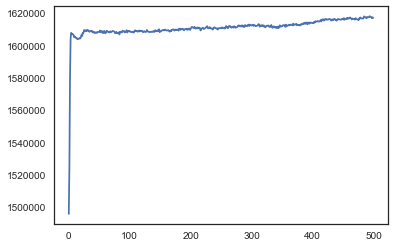

In [12]:
# Fit an LDS to all the data
fit_joint_lds = cached("lds_joint")(_fit_lds)
# fit_joint_lds = (_fit_lds)
lds, lds_lls, lds_x_finals, lds_sigma_x_finals = \
        fit_joint_lds(x_inits=None, 
                      ys=[y[:,:D_obs] for y in datasets], 
                      masks=[m[:,:D_obs] for m in data_masks], 
                      N_gibbs=500)
    
plt.plot(lds_lls)

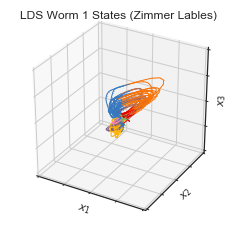

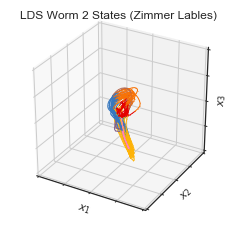

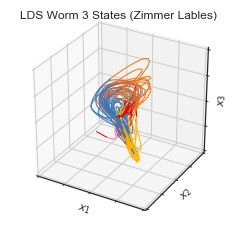

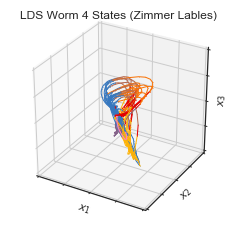

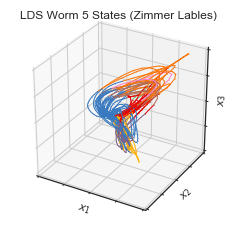

In [13]:
# False color with the "true" label from Zimmer
for worm in range(N_worms):
    plot_3d_continuous_states(lds_x_finals[worm], z_trues[worm], colors,
                              figsize=(4, 4),
                              title="LDS Worm {} States (Zimmer Lables)".format(worm + 1),
                              results_dir=results_dir,
                              filename="lds_x_worm_zimmer_{}.pdf".format(worm + 1),
                              lim=40,
                              lw=1)

100%|██████████| 360/360 [00:16<00:00, 22.27it/s]


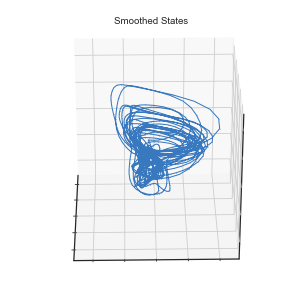

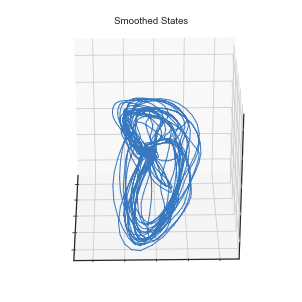

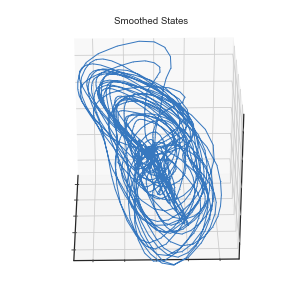

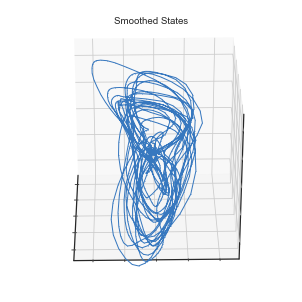

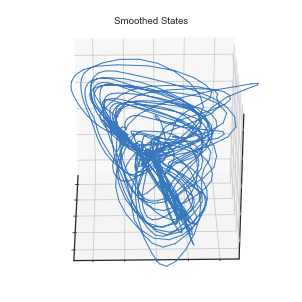

In [94]:
for worm in range(N_worms):
    make_states_3d_movie(np.zeros(Ts[worm], dtype=int), lds_x_finals[worm],
                         title="Smoothed States",
                         filepath=os.path.join(results_dir, "lds_x_worm{}.mp4".format(worm+1)),
                         lim=25)

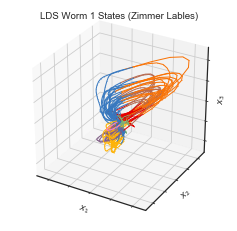

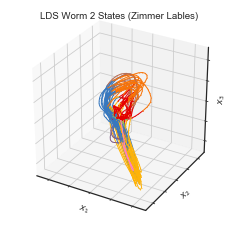

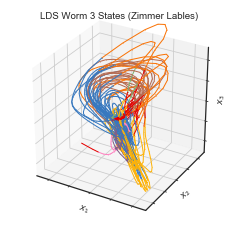

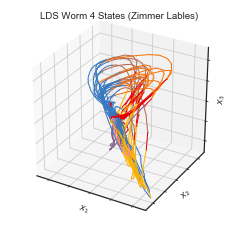

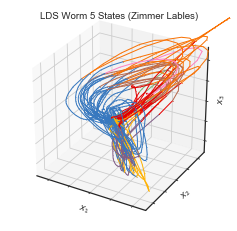

In [95]:
# False color with the "true" label from Zimmer
for worm in range(N_worms):
    plot_3d_continuous_states(lds_x_finals[worm], z_trues[worm], colors,
                              figsize=(4, 4),
                              title="LDS Worm {} States (Zimmer Lables)".format(worm + 1),
                              results_dir=results_dir,
                              filename="lds_x_worm_zimmer_{}.pdf".format(worm + 1),
                              lim=25,
                              lw=1)

100%|██████████| 360/360 [00:34<00:00, 11.49it/s]


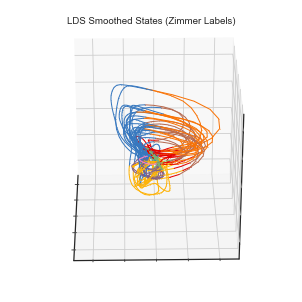

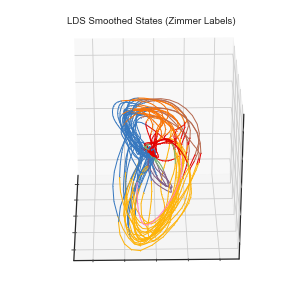

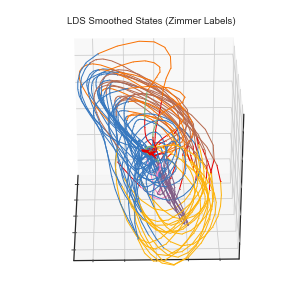

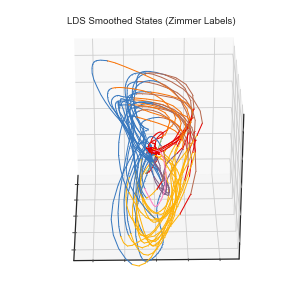

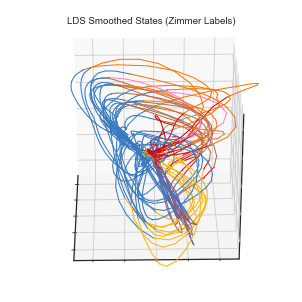

In [96]:
# False color with the "true" label from Zimmer
for worm in range(N_worms):
    make_states_3d_movie(z_trues[worm], lds_x_finals[worm],
                         title="LDS Smoothed States (Zimmer Labels)",
                         filepath=os.path.join(results_dir, "lds_x_worm_zimmer_{}.mp4".format(worm+1)),
                         lim=25)

In [98]:
# # Fit an LDS to each worm individually
# lds_results = []
# for worm in range(N_worms):
#     fit_lds = cached("lds_worm_{}".format(worm+1))(_fit_lds)
#     lds_results.append(fit_lds(x_inits=x_inits[worm:worm+1], ys=datasets[worm:worm+1], masks=data_masks[worm:worm+1]))
# ldss, lds_llss, lds_x_finalss, lds_sigma_x_finalss = zip(*lds_results)
    

# Fit standard SLDS models

In [14]:
def _fit_slds(z_inits, ys, masks, N_samples=500, N_vbem=100, init_lds=None):
    print("Fitting standard SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_slds_parameters()
        
    z_inits = [None] * len(ys) if z_inits is None else z_inits
    
    slds = WeakLimitStickyHDPHMMSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        gamma=gamma,
        kappa=kappa,
        init_state_distn='uniform')

    # Add the data
    for y, mask, zi in zip(ys, masks, z_inits):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        slds.add_data(data=y, mask=mask, inputs=inputs)

        # Initialize discrete latent states
        if zi is not None:
            slds.states_list[-1].stateseq = zi
        else:
            runlen = 10
            z0 = np.random.choice(Kmax, size=(T // 10))
            z0 = np.repeat(z0, runlen)
            z0 = z0[:T] if len(z0) > T else z0
            z0 = np.concatenate((z0, z0[-1] * np.ones(T - len(z0))))
            z0 = z0.astype(np.int32)
            assert len(z0) == T
            slds.states_list[-1].stateseq = z0
            
    if init_lds is not None:
        assert len(init_lds.states_list) == len(ys)
        slds._emission_distn = copy.deepcopy(init_lds._emission_distn)
            
        for s1,s2 in zip(init_lds.states_list, slds.states_list):
            s2.gaussian_states = s1.gaussian_states.copy()

        for k in range(Kmax):
            slds.init_dynamics_distns[k] = copy.deepcopy(init_lds.init_dynamics_distns[0])
            slds.dynamics_distns[k] = copy.deepcopy(init_lds.dynamics_distns[0])
            slds.emission_distns[k] = slds._emission_distn
            
    # Resample parameters once to be consistent with x_init
    else:
        slds.resample_parameters()

    # Fit the model with MCMC
    def evaluate(model):
        ll = model.log_likelihood()
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def update(model):
        model.resample_model()
        return evaluate(model)

    smpls = [update(slds) for itr in progprint_xrange(N_samples)]
    
    # Now refine the model with VBEM
    for s in slds.states_list:
        s._init_mf_from_gibbs()
        s.vb_E_step_gaussian_states()
        
    def update_vbem(model):
        model.VBEM_step()
        return evaluate(model)
        
    smpls += [update_vbem(slds) for itr in progprint_xrange(N_vbem)]
    

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(len(ys)):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    perm_z_smpls, iperm = relabel_by_usage(z_smpls, return_mapping=True)
    perm = np.argsort(iperm)
    z_finals = [relabel_by_permutation(s.stateseq, iperm) for s in slds.states_list]
    
    # Permute the dynamics and transition distribution
    perm_init_dynamics_distns = [slds.init_dynamics_distns[i] for i in perm]
    perm_dynamics_distns = [slds.dynamics_distns[i] for i in perm]
    perm_trans_matrix = slds.trans_distn.trans_matrix[np.ix_(perm, perm)]
    
    # Update the model accordingly
    slds.init_dynamics_distns = perm_init_dynamics_distns
    slds.dynamics_distns = perm_dynamics_distns
    slds.trans_distn.trans_matrix = perm_trans_matrix
    for s, zp in zip(slds.states_list, z_finals):
        s.stateseq = zp.copy()

    # Compute the smoothed continuous state trajectories
    for states in slds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in slds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in slds.states_list]

    return slds, lls, perm_z_smpls, perm_dynamics_distns, z_finals, x_finals, sigma_x_finals

In [15]:
fit_joint_slds = cached("slds_joint")(_fit_slds)
# fit_joint_slds = _fit_slds
slds, slds_lls, slds_z_smpls, slds_dynamics_distns, \
    slds_z_finals, slds_x_finals, slds_sigma_x_finals = \
        fit_joint_slds(z_inits=None, 
                       ys=[y[:,:D_obs] for y in datasets], 
                       masks=[m[:,:D_obs] for m in data_masks], 
                       init_lds=lds,
                       N_samples=1000)

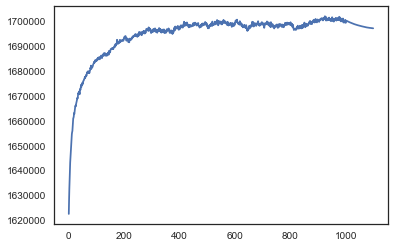

In [16]:
plt.plot(slds_lls[1:])

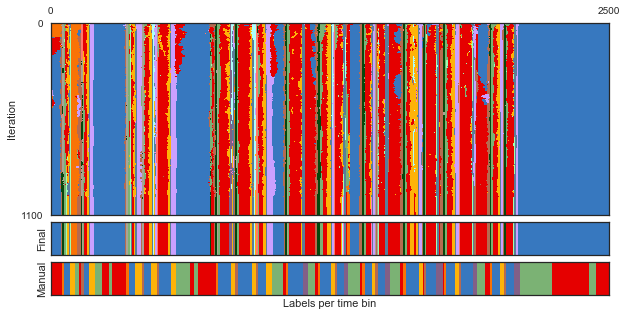

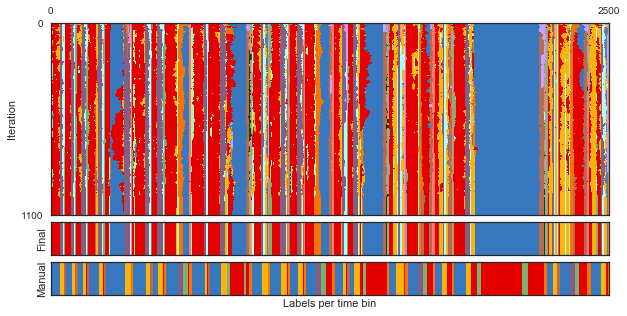

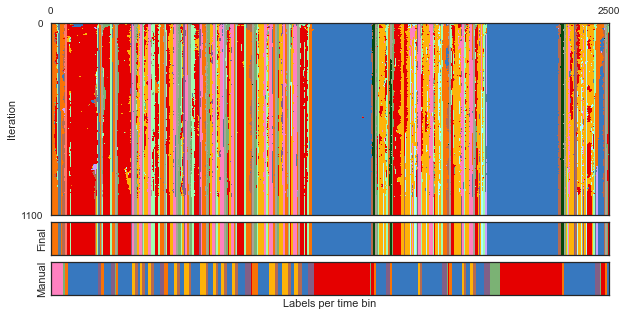

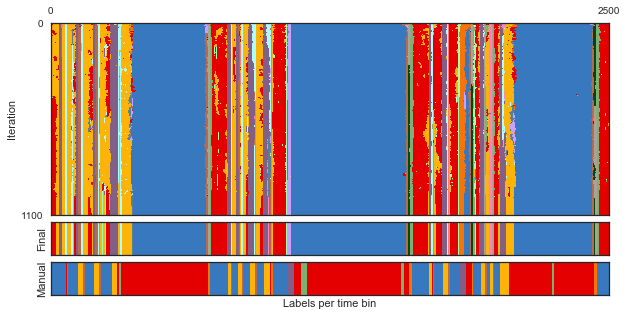

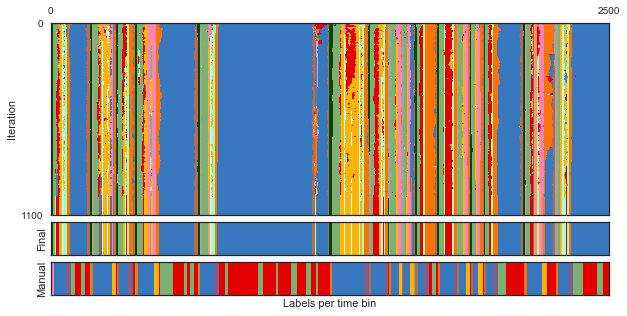

In [17]:
for worm in range(N_worms):
    plot_discrete_state_samples(
        slds_z_smpls[worm], z_trues[worm], Kmax,
        filepath=os.path.join(results_dir, "slds_z_samples_worm{}.pdf".format(worm+1)))
    

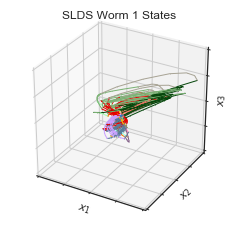

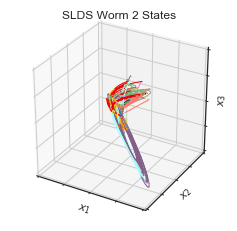

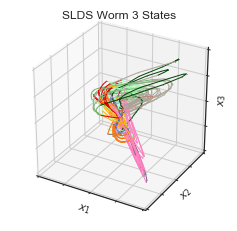

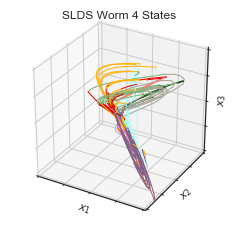

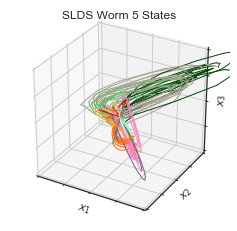

In [18]:
for worm in range(N_worms):
    plot_3d_continuous_states(slds_x_finals[worm], slds_z_finals[worm], colors,
                              figsize=(4, 4),
                              title="SLDS Worm {} States".format(worm + 1),
                              results_dir=results_dir,
                              filename="slds_x_worm_{}.pdf".format(worm + 1),
                              lw=1,
                              lim=40)

100%|██████████| 360/360 [00:52<00:00,  6.10it/s]


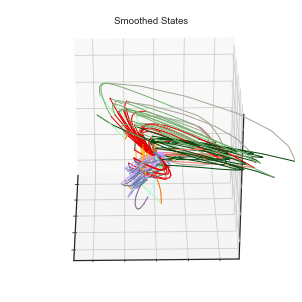

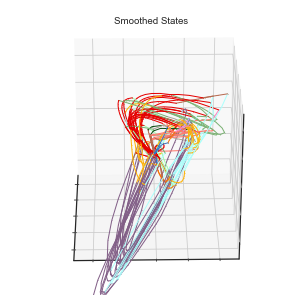

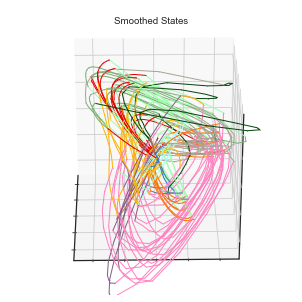

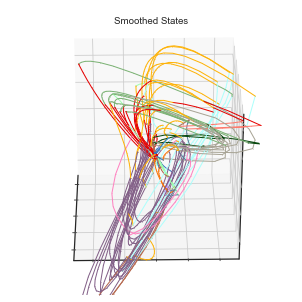

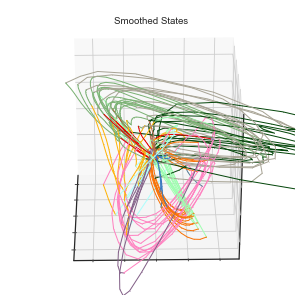

In [99]:
for worm in range(N_worms):
    make_states_3d_movie(slds_z_finals[worm], slds_x_finals[worm],
                         title="Smoothed States",
                         filepath=os.path.join(results_dir, "slds_x_worm{}.mp4".format(worm+1)),
                         lim=25)

# Fit hierarchical SLDS models

In [19]:
def make_hierarchical_slds_parameters():
    init_dynamics_distns = [
        Gaussian(
            mu=np.zeros(D_latent),
            sigma=3*np.eye(D_latent),
            nu_0=D_latent + 2, sigma_0=3. * np.eye(D_latent),
            mu_0=np.zeros(D_latent), kappa_0=1.0,
        )
        for _ in range(Kmax)]

    # dynamics_hypparams = get_empirical_ar_params(
    #     [np.hstack((np.vstack(pca_trajs)[:,:P], np.ones((sum(Ts), 1))))],
    #     dynamics_hypparams)

    As = [np.hstack((0.99 * np.eye(D_latent), np.zeros((D_latent, D_in)))) for _ in range(Kmax)]
    dynamics_distns = [
        Regression(
            A=As[k],
            sigma=np.eye(D_latent),
            nu_0=D_latent + D_in + 2,
            S_0=np.eye(D_latent),
            M_0=np.hstack((np.eye(D_latent), np.zeros((D_latent, D_in)))),
            K_0=np.eye(D_latent + D_in),
        )
        for k in range(Kmax)]

    # Scale down the strength of the prior since we have separate variances
    # for each worm. I.e. we should divide alpha and beta by N_worms.
    emission_distns = \
        HierarchicalDiagonalRegression(
            D_obs, D_latent + D_in, N_worms,
            alpha_0=alpha_0 / N_worms, beta_0=beta_0 / N_worms)

    return init_dynamics_distns, dynamics_distns, emission_distns

In [20]:
@cached("hslds")
def fit_hslds(ys, masks, init_slds=None, N_samples=500):
    print("Fitting hierarchical SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_hierarchical_slds_parameters()

    hslds = HierarchicalWeakLimitStickyHDPHMMSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        gamma=gamma,
        kappa=kappa,
        init_state_distn='uniform')

    # Add the data
    for worm, (y, mask) in enumerate(zip(ys, masks)):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        hslds.add_data(data=y, mask=mask, group=worm, inputs=inputs)

    if init_slds is not None:
        assert len(init_slds.states_list) == len(ys)

        for s1,s2 in zip(init_slds.states_list, hslds.states_list):
            s2.stateseq = s1.stateseq.copy()
            s2.gaussian_states = s1.gaussian_states.copy()

        hslds.init_dynamics_distns = copy.deepcopy(init_slds.init_dynamics_distns)
        hslds.dynamics_distns = copy.deepcopy(init_slds.dynamics_distns)
        hslds._emission_distn.A = copy.deepcopy(init_slds.emission_distns[0].A)
        hslds._emission_distn.sigmasq_flat = np.tile(init_slds.emission_distns[0].sigmasq_flat[None,:], (N_worms,1))
        assert hslds._emission_distn.sigmasq_flat.shape == (N_worms, D_obs)
        for k in range(Kmax):
            hslds.emission_distns[k] = hslds._emission_distn
        slds._single_emission = True
    
    else:
        # Resample parameters once to be consistent with x_init
        hslds.resample_parameters()

    # Fit the model with MCMC
    def evaluate(model):
        # ll = model.log_likelihood()
        ll = model.heldout_log_likelihood(masks)
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def gibbs_update(model):
        model.resample_model()
        return evaluate(model)
    
    # Initialize with Gibbs
    smpls = [evaluate(hslds)] + [gibbs_update(hslds) for itr in progprint_xrange(N_samples)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)
        
    # Compute the smoothed continuous state trajectories
    for states in hslds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in hslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in hslds.states_list]

    return hslds, lls, z_smpls, hslds.dynamics_distns, hslds.stateseqs, x_finals, sigma_x_finals

hslds0, hslds_lls0, hslds_z_smpls0, hslds_dynamics_distns0, \
    hslds_z_finals0, hslds_x_finals0, hslds_sigma_x_finals0 = \
        fit_hslds(ys=[y[:,:D_obs] for y in datasets], 
                  masks=[m[:,:D_obs] for m in data_masks], 
                  N_samples=500, init_slds=slds)

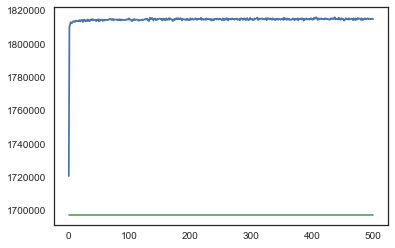

In [21]:
plt.plot(hslds_lls0)
plt.plot(slds_lls[-1] * np.ones(500))

### Refine estimate with VBEM


In [22]:
@cached("hslds_vbem")
def fit_hslds_with_vbem(hslds, N_vbem_steps=100):
    print("Fitting hierarchical SLDS with VBEM")
        
    for s in hslds.states_list:
        s._init_mf_from_gibbs()
        s.vb_E_step_gaussian_states()
        
    # Refine with VBEM
    def evaluate(model):
        # ll = model.log_likelihood()
        ll = model.heldout_log_likelihood([m[:,:D_obs] for m in data_masks])
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs
    
    def vbem_update(model):
        model.VBEM_step()
        return evaluate(model)

    smpls = [evaluate(hslds)] + [vbem_update(hslds) for itr in progprint_xrange(N_vbem_steps)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    z_finals = hslds.stateseqs
    x_finals = [s.smoothed_mus for s in hslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in hslds.states_list]
    
    # Clear the expected stats before saving
    for s in hslds.states_list:
        s.E_init_stats = None
        s.E_dynamics_stats = None
        s.E_emission_stats = None

    return hslds, lls, z_smpls, hslds.dynamics_distns, z_finals, x_finals, sigma_x_finals

hslds = copy.deepcopy(hslds0)

hslds, hslds_lls, hslds_z_smpls, hslds_dynamics_distns, \
    hslds_z_finals, hslds_x_finals, hslds_sigma_x_finals = \
        fit_hslds_with_vbem(hslds, N_vbem_steps=100)

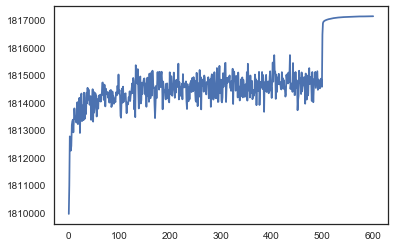

In [23]:
plt.plot(np.concatenate([hslds_lls0[1:], hslds_lls], axis=0))
# plt.plot(np.concatenate([hslds_lls], axis=0))

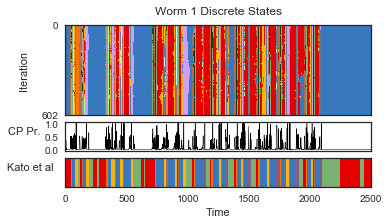

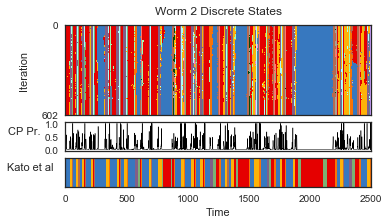

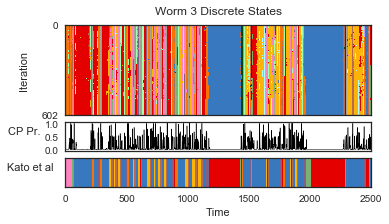

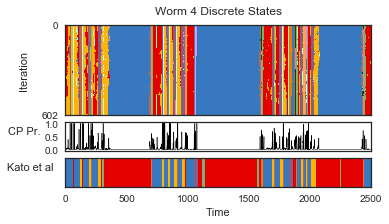

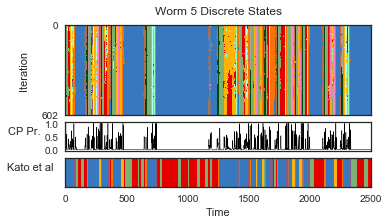

In [24]:
for worm in range(N_worms):
    plot_changepoint_prs(np.vstack((hslds_z_smpls0[worm], hslds_z_smpls[worm])), 
                         z_trues[worm],
                         title="Worm {} Discrete States".format(worm+1),
                         plt_slice=(0,2500),
                         filepath=os.path.join(results_dir, "hslds_cps_worm{}.pdf".format(worm+1)))
    

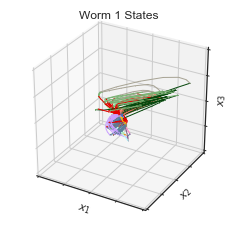

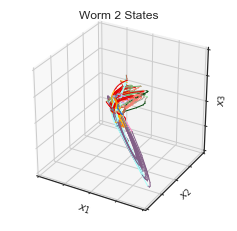

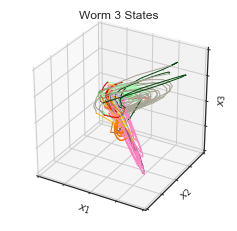

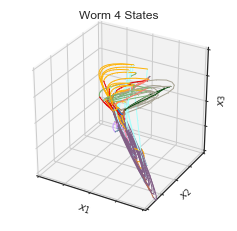

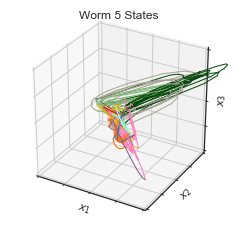

In [25]:
for worm in range(N_worms):
    plot_3d_continuous_states(hslds_x_finals[worm], hslds_z_finals[worm], colors,
                              figsize=(4, 4),
                              title="Worm {} States".format(worm + 1),
                              lim=40,
                              results_dir=results_dir,
                              filename="hslds_x_worm_{}.pdf".format(worm + 1),
                              lw=1)

100%|██████████| 360/360 [00:45<00:00,  7.68it/s]


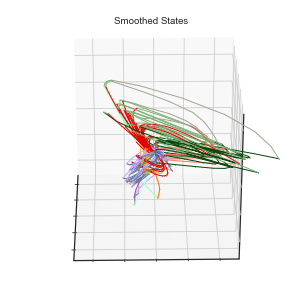

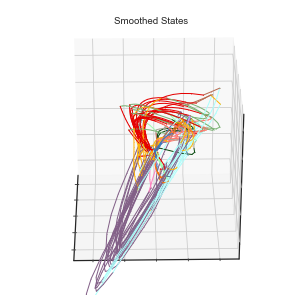

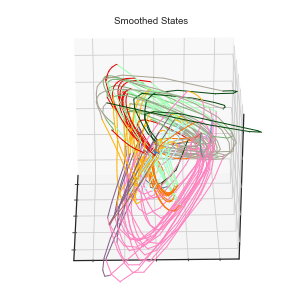

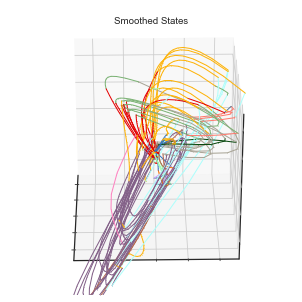

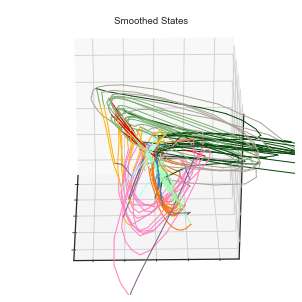

In [100]:
for worm in range(N_worms):
    make_states_3d_movie(hslds_z_finals[worm], hslds_x_finals[worm],
                         title="Smoothed States",
                         lim=25,
                         filepath=os.path.join(results_dir, "hslds_x_worm{}.mp4".format(worm+1)))

# Now fit a hierarchical _recurrent_ hSLDS

In [26]:
@cached("rhslds")
def fit_hrslds(ys, masks, N_steps=100, init_hslds=None):
    print("Fitting hierarchical recurrent SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_hierarchical_slds_parameters()

    rslds = HierarchicalRecurrentSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        init_state_distn='uniform')

    # Add the data
    for worm, (y, mask) in enumerate(zip(ys, masks)):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        rslds.add_data(data=y, mask=mask, group=worm, inputs=inputs)

    # If we've been given an hSLDS to initialize from, use its states and parameters
    if init_hslds is not None:            
        # Copy over the parameters
        rslds.init_dynamics_distns = copy.deepcopy(init_hslds.init_dynamics_distns)
        rslds.dynamics_distns = copy.deepcopy(init_hslds.dynamics_distns)
        rslds.emission_distns = copy.deepcopy(init_hslds.emission_distns)

        # Copy over the latent states
        assert len(init_hslds.states_list) == len(ys)
        for s1, s2 in zip(init_hslds.states_list, rslds.states_list):
            # Copy the sampled states
            s2.stateseq = s1.stateseq.copy()
            s2.gaussian_states = s1.gaussian_states.copy()

            # Copy the expected states and statistics
            s2.expected_states = s1.expected_states.copy()
            s2.smoothed_mus = s1.smoothed_mus.copy()
            s2.smoothed_sigmas = s1.smoothed_sigmas.copy()
            
            if s1.E_emission_stats is None:
                s1.vb_E_step_gaussian_states()
                
            s2.E_init_stats = copy.deepcopy(s1.E_init_stats)
            s2.E_dynamics_stats = copy.deepcopy(s1.E_dynamics_stats)
            s2.E_emission_stats = copy.deepcopy(s1.E_emission_stats)
        
            s2.expected_joints = s2.expected_states[:-1, :, None] * s2.expected_states[1:, None, :]
            s2._set_expected_trans_stats()

        
        # Initialize the transition model with the latent states
        rslds.initialize_transitions_from_gibbs()
        
        # Initialize the transition model to ignore continuous location
        # rslds.trans_distn.W *= 0
        # rslds.trans_distn.logpi = np.log(init_hslds.trans_distn.trans_matrix)

        # Initialize the auxiliary latent variables to be consistent
        # with the discrete and continuous latent states as well as 
        # the transition model
        for s in rslds.states_list:
            # s._init_vbem_from_gibbs()
            s.vbem_update_auxiliary_vars(n_iter=100)
            s._variational_entropy = 0

    else:
        for s in rslds.states_list:
            s._init_vbem_from_gibbs()
            s._variational_entropy = 0

    # Fit the model with VBEM
    def evaluate(model):
        ll = model.heldout_log_likelihood(masks)
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def update(model, itr):
        model.VBEM_step()
        return evaluate(model)


    smpls = [evaluate(rslds)] + [update(rslds, itr) for itr in progprint_xrange(N_steps)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    z_finals = rslds.stateseqs
    x_finals = [s.smoothed_mus for s in rslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in rslds.states_list]

    # Clear the expected stats before saving
    for s in rslds.states_list:
        s.E_init_stats = None
        s.E_dynamics_stats = None
        s.E_emission_stats = None
    
    return rslds, lls, z_smpls, rslds.dynamics_distns, z_finals, x_finals, sigma_x_finals

# Make and fit the hierarchical rSLDS
hrslds, hrslds_lls, hrslds_z_smpls, hrslds_dynamics_distns, \
hrslds_z_finals, hrslds_x_finals, hrslds_sigma_x_finals = \
    fit_hrslds(ys=[y[:,:D_obs] for y in datasets], 
               masks=[m[:,:D_obs] for m in data_masks], 
               N_steps=100, init_hslds=hslds)

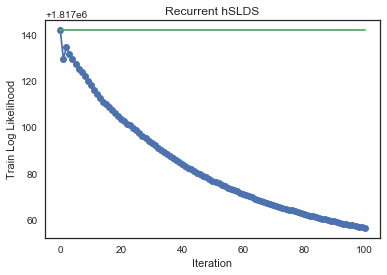

In [27]:
plt.plot(hrslds_lls, '-o')
# tmp = hslds.heldout_log_likelihood(data_masks_train)
# plt.plot(tmp * np.ones(len(hrslds_lls)))
tmp = hslds.heldout_log_likelihood([m[:,:D_obs] for m in data_masks])
plt.plot(tmp * np.ones(len(hrslds_lls)))
plt.xlabel("Iteration")
plt.ylabel("Train Log Likelihood")
plt.title("Recurrent hSLDS")

# Plot recurrent hSLDS results

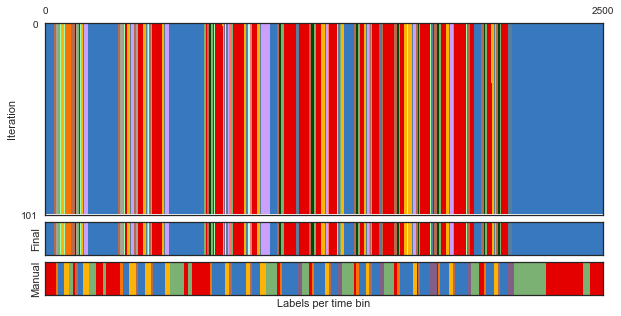

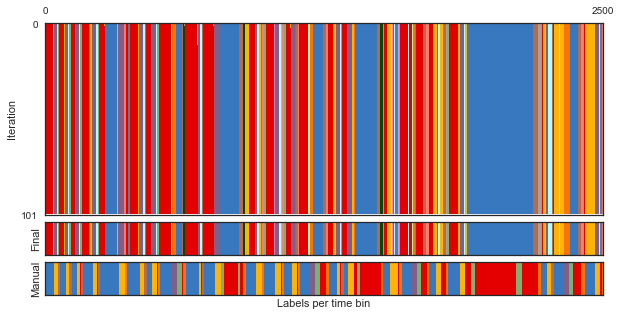

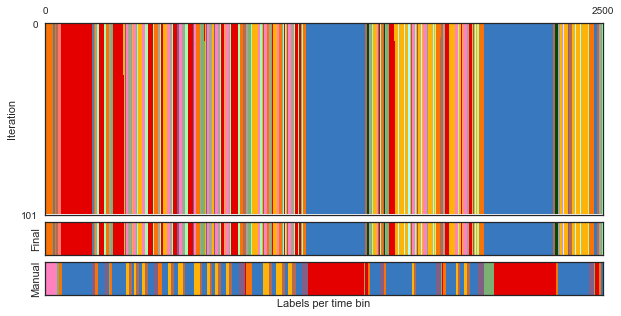

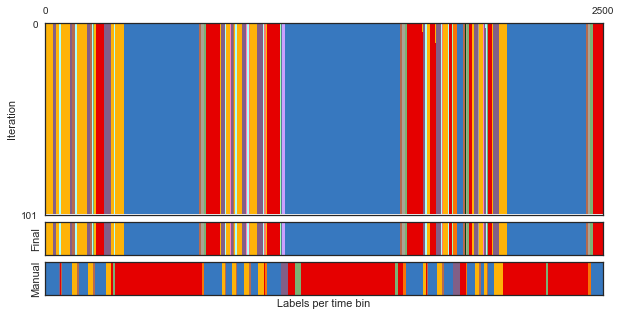

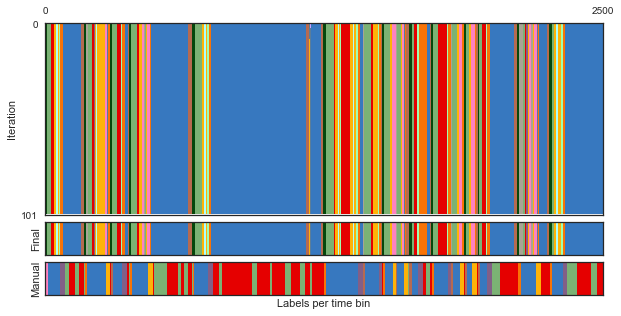

In [28]:
# Note: name the files (r)ecuzrrent (h)ierarhical instead of hr... 
#       this will make it easier to navigate the results directory
for worm in range(N_worms):
    plot_discrete_state_samples(
        hrslds_z_smpls[worm], z_trues[worm], Kmax,
        filepath=os.path.join(results_dir, "rhslds_z_samples_worm{}.pdf".format(worm+1)))

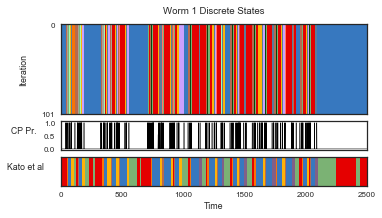

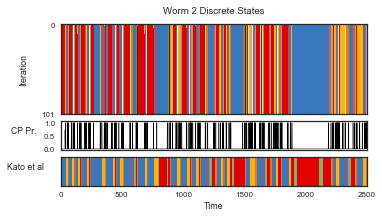

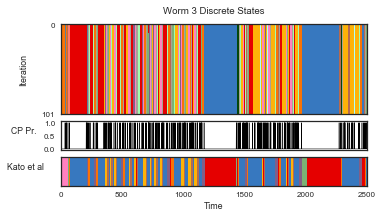

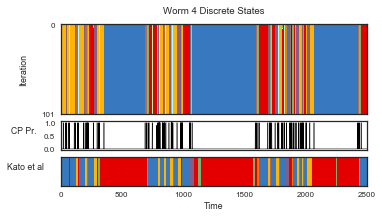

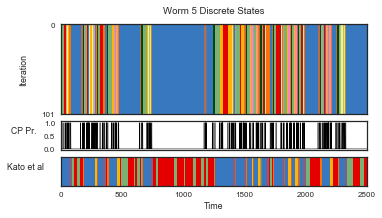

In [101]:
for worm in range(N_worms):
    plot_changepoint_prs(hrslds_z_smpls[worm], z_trues[worm],
                         title="Worm {} Discrete States".format(worm+1),
                         filepath=os.path.join(results_dir, "rhslds_cps_worm{}.pdf".format(worm+1)))

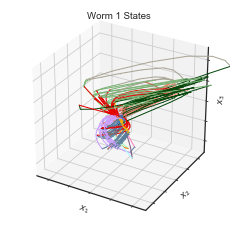

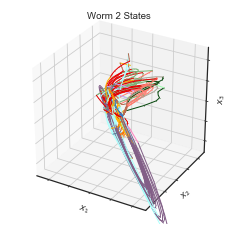

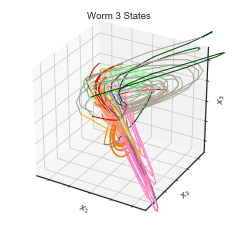

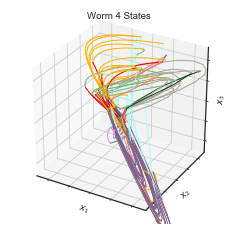

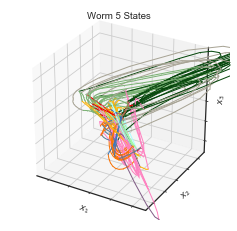

In [102]:
for worm in range(N_worms):
    plot_3d_continuous_states(hrslds_x_finals[worm], hrslds_z_finals[worm], colors,
                              figsize=(4, 4),
                              title="Worm {} States".format(worm + 1),
                              lim=25,
                              results_dir=results_dir,
                              filename="rhslds_x_worm_{}.pdf".format(worm + 1),
                              lw=1)

100%|██████████| 360/360 [00:46<00:00,  4.60it/s]


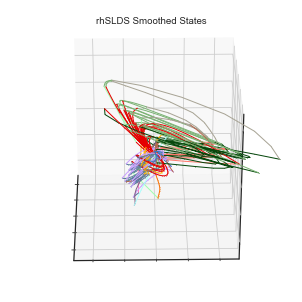

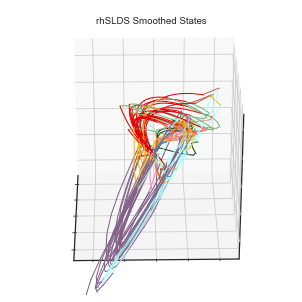

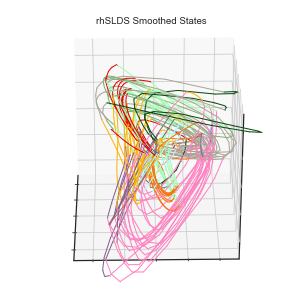

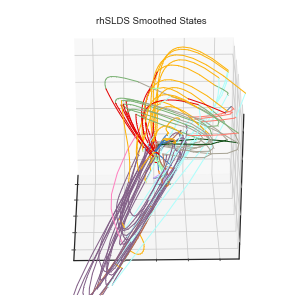

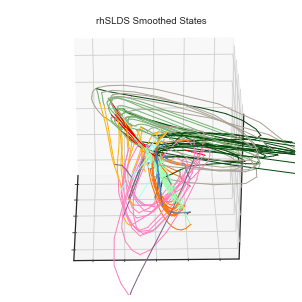

In [103]:
for worm in range(N_worms):
    make_states_3d_movie(hrslds_z_finals[worm], hrslds_x_finals[worm],
                         title="rhSLDS Smoothed States",
                         lim=25,
                         filepath=os.path.join(results_dir, "rhslds_x_worm{}.mp4".format(worm+1)))

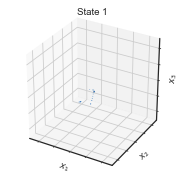

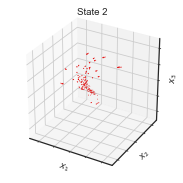

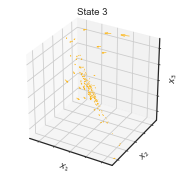

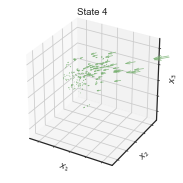

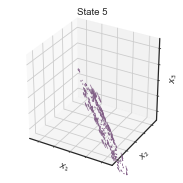

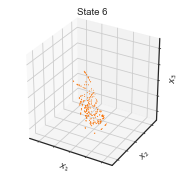

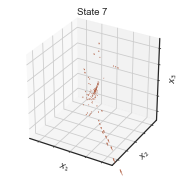

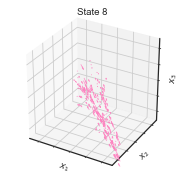

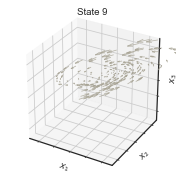

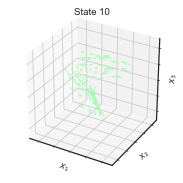

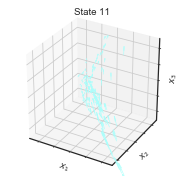

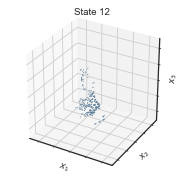

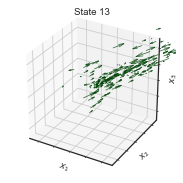

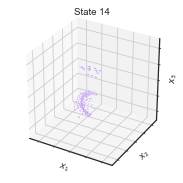

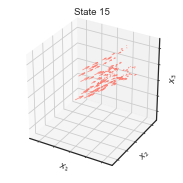

In [104]:
plot_3d_dynamics(
    hrslds_dynamics_distns, np.concatenate(hrslds_z_finals), np.vstack(hrslds_x_finals),
    colors=colors,
    lim=25,
    filepath=os.path.join(results_dir, "rhslds_dynamics.pdf"))


100%|██████████| 360/360 [00:21<00:00, 16.48it/s]


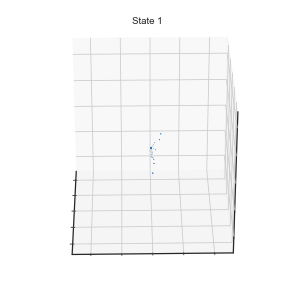

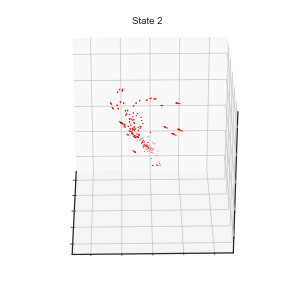

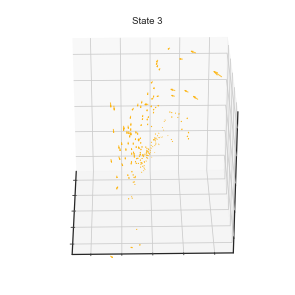

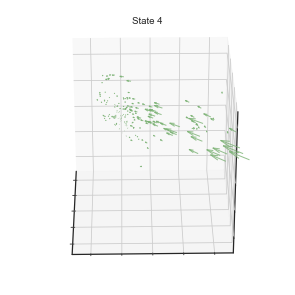

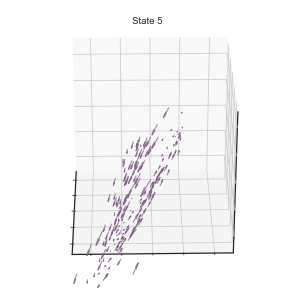

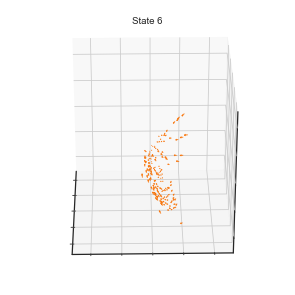

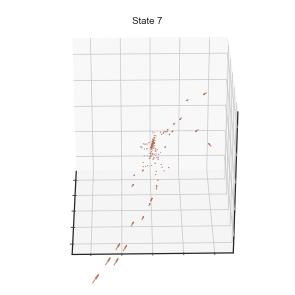

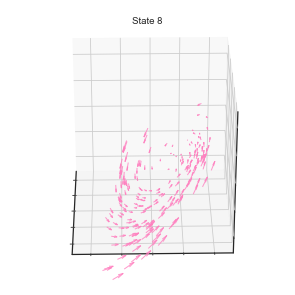

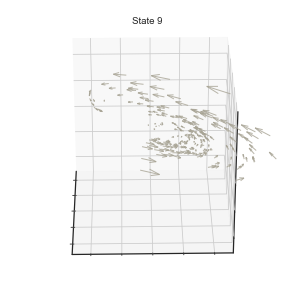

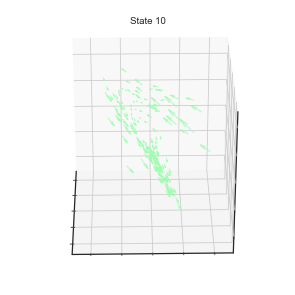

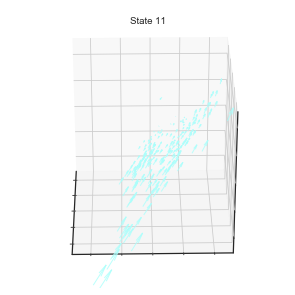

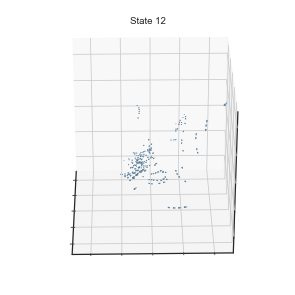

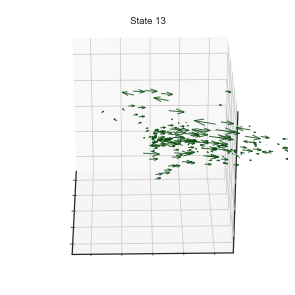

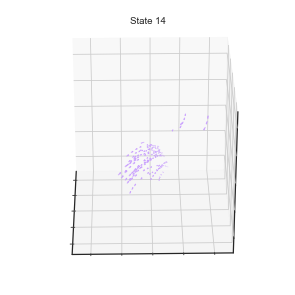

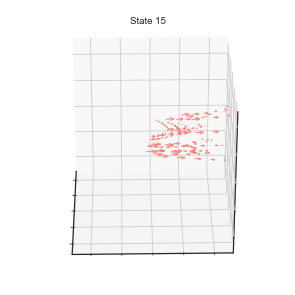

In [105]:
 make_states_dynamics_movie(
    hrslds_dynamics_distns, np.concatenate(hrslds_z_finals), np.vstack(hrslds_x_finals),
    colors=colors,
    lim=25,
    filepath=os.path.join(results_dir, "rhslds_dynamics"))

# State usage across worms

[array([1, 1, 1, ..., 3, 3, 3]),
 array([1, 1, 0, ..., 1, 1, 1]),
 array([1, 1, 7, ..., 7, 7, 7]),
 array([1, 1, 0, ..., 1, 1, 1]),
 array([1, 1, 7, ..., 0, 0, 0])]

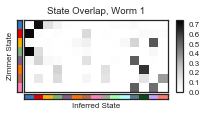

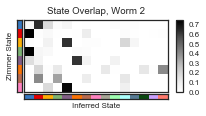

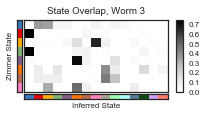

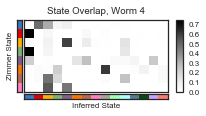

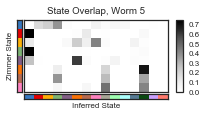

In [125]:
# Compare zimmer labels to inferred labels
K_zimmer = np.concatenate(z_trues).max() + 1
for worm, (z_true, z_inf) in enumerate(zip(z_trues, hrslds_z_finals)):
    overlap = np.zeros((K_zimmer, Kmax), dtype=float)
    for k1 in range(K_zimmer):
        for k2 in range(Kmax):
            overlap[k1, k2] = np.sum((z_true == k1) & (z_inf == k2))
    
    # Normalize the rows
    overlap /= overlap.sum(1)[:,None]
    
    fig = plt.figure(figsize=(3, 2))
    ax1 = create_axis_at_location(fig, .5, .5, 2, 1)
    im = ax1.imshow(overlap, vmin=0, vmax=.75, interpolation="nearest", aspect="auto")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title("State Overlap, Worm {}".format(worm+1))
    
    lax = create_axis_at_location(fig, .4, .5, .06, 1)
    lax.imshow(np.arange(K_zimmer)[:,None], cmap=gradient_cmap(colors[:K_zimmer]), interpolation="nearest", aspect="auto")
    lax.set_xticks([])
    lax.set_yticks([])
    lax.set_ylabel("Zimmer State", fontsize=8)
    
    bax = create_axis_at_location(fig, .5, .4, 2, .06)
    bax.imshow(np.arange(Kmax)[None,:], cmap=gradient_cmap(colors[:Kmax]), interpolation="nearest", aspect="auto")
    bax.set_xticks([])
    bax.set_yticks([])
    bax.set_xlabel("Inferred State", fontsize=8)
    
    axcb = create_axis_at_location(fig, 2.6, .5, .1, 1)
    plt.colorbar(im, cax=axcb)
    
    plt.savefig(os.path.join(results_dir, "state_overlap_worm_{}.pdf".format(worm)))
    


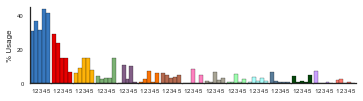

In [29]:
usage = np.zeros((N_worms, Kmax))
for worm in range(N_worms):
    usage[worm] = np.bincount(hrslds_z_finals[worm], minlength=Kmax)
    
usage = usage / usage.sum(axis=1)[:,None]

sns.set_context("paper")
fig = plt.figure(figsize=(5, 1.25))
gs = GridSpec(1, Kmax)
for k in range(Kmax):
    ax = fig.add_subplot(gs[0,k])
    ax.bar(np.arange(N_worms), usage[:,k], width=1, color=colors[k], edgecolor="k")
#     ax.set_title("State {}".format(k+1), fontsize=6)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks(np.arange(N_worms))
    ax.set_xticklabels(np.arange(1, N_worms+1), fontsize=6)
    ax.set_ylim(0, 0.45)
    if k > 0:
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
    else:
        ax.set_yticks([0, .2, .4])
        ax.set_yticklabels([0, 20, 40], fontsize=6)
        ax.set_ylabel("% Usage", fontsize=8)
    
#     if k == 7:
#         ax.set_xlabel("Worm", fontsize=8)
    
plt.tight_layout(rect=(0.01, 0.01, 0.98, 0.98), pad=0.01)
plt.savefig(os.path.join(results_dir, "state_usage_per_worm.pdf"))

(15, 15)
(15, 15)
(15, 15)
(15, 15)
(15, 15)


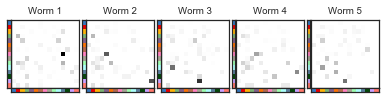

In [30]:
# Plot the transition matrices for each worm

def _plot_transition_matrix(ax, P, colors, cmap, vmax=None, plot_colorbar=False):

    K = P.shape[0]
    # View the off diagonal elements
    Pod = P - np.diag(np.diag(P))
    vmax = np.max(Pod) if vmax is None else vmax
    im = ax.imshow(Pod, interpolation="nearest", cmap="Greys", vmin=0, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.set_xlabel("$z_{t+1}$", fontsize=15, labelpad=30)
#     ax.set_ylabel("$z_{t}$", fontsize=15, labelpad=30)
#     ax.set_title("Off Diagonal Only", fontsize=18)


    divider = make_axes_locatable(ax)
    lax = divider.append_axes("left", size="5%", pad=0.01)
    lax.imshow(np.arange(K)[:, None], cmap=cmap, vmin=0, vmax=len(colors) - 1, aspect="auto",
               interpolation="nearest")
    lax.set_xticks([])
    lax.set_yticks([])

    bax = divider.append_axes("bottom", size="5%", pad=0.01)
    bax.imshow(np.arange(K)[None, :], cmap=cmap, vmin=0, vmax=len(colors) - 1, aspect="auto",
               interpolation="nearest")
    bax.set_xticks([])
    bax.set_yticks([])

    if plot_colorbar:
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    
from pyhsmm.util.general import count_transitions
fig = plt.figure(figsize=(5.25, 1.35))
for worm in range(N_worms):
    ax = fig.add_subplot(1,N_worms, worm+1)
    trans_matrix = np.zeros((Kmax, Kmax))
    for z1, z2 in zip(hrslds_z_finals[worm][:-1], hrslds_z_finals[worm][1:]):
        trans_matrix[z1, z2] += 1
#     trans_matrix2 = count_transitions(hrslds_z_finals[worm]).astype(np.float)
#     assert np.allclose(trans_matrix, trans_matrix2)
    trans_matrix /= (1e-8 + trans_matrix.sum(1)[:,None])
    print(trans_matrix.shape)
    _plot_transition_matrix(ax, trans_matrix, colors=colors, cmap=gradient_cmap(colors), vmax=0.4)
    ax.set_title("Worm {}".format(worm+1))
    
plt.tight_layout(pad=0.33)
plt.savefig(os.path.join(results_dir, "trans_matrices.pdf"))

0.0 0.12753623188
-0.0775362319054 0.484513271837
-0.0395362318874 0.274652338404
-0.0668449197843 0.329836828726
-0.0679012345637 0.17075623475
-0.0679012345637 0.246503495879


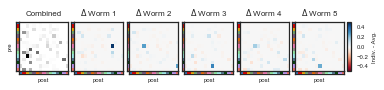

In [86]:
# Plot difference from the average transition matrices for each worm

def _plot_transition_matrix(ax, lax, bax, P, colors, offdiag=True, vmin=0, vmax=None, cmap="Greys", plot_colorbar=False):

    K = P.shape[0]
    # View the off diagonal elements
    Pod = P - np.diag(np.diag(P)) if offdiag else P
    print(np.min(Pod), np.max(Pod))
    vmax = np.max(Pod) if vmax is None else vmax
    im = ax.imshow(Pod, interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])

    lax.imshow(np.arange(K)[:, None], cmap=gradient_cmap(colors), vmin=0, vmax=len(colors) - 1, aspect="auto",
               interpolation="nearest")
    lax.set_xticks([])
    lax.set_yticks([])

    bax.imshow(np.arange(K)[None, :], cmap=gradient_cmap(colors), vmin=0, vmax=len(colors) - 1, aspect="auto",
               interpolation="nearest")
    bax.set_xticks([])
    bax.set_yticks([])

    if plot_colorbar:
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    return im
    
from pyhsmm.util.general import count_transitions
lpad = 0.15
bpad = 0.15
pad = 0.05
figw = 5.25
cbarpanw = 0.45
panh = panw = (figw -lpad - 7*pad - cbarpanw) / 6
figh = bpad + panh + .25
fig = plt.figure(figsize=(figw, figh))
axh = axw = .95 * panw
laxw = .05 * panw
baxh = laxw

# ax = fig.add_subplot(1, 1+N_worms, 1)
lax = create_axis_at_location(fig, lpad, bpad+baxh, laxw, axh)
bax = create_axis_at_location(fig, lpad+laxw, bpad, axw, baxh)
ax = create_axis_at_location(fig, lpad+laxw, bpad+baxh, axw, axh)
avg_trans_matrix = count_transitions(np.concatenate(hrslds_z_finals)).astype(np.float)
avg_trans_matrix /= (1e-8 + avg_trans_matrix.sum(1)[:,None])
_plot_transition_matrix(ax, lax, bax, avg_trans_matrix, colors=colors, cmap="Greys", vmax=None)
ax.set_title("Combined", fontsize=8)
lax.set_ylabel("pre", fontsize=6)
bax.set_xlabel("post", fontsize=6)

lim = 0.5
for worm in range(N_worms):
    lax = create_axis_at_location(fig, lpad+(1+worm)*(panw+pad), bpad+baxh, laxw, axh)
    bax = create_axis_at_location(fig, lpad+(1+worm)*(panw+pad)+laxw, bpad, axw, baxh)
    ax = create_axis_at_location(fig, lpad+(1+worm)*(panw+pad)+laxw, bpad+baxh, axw, axh)

    trans_matrix = np.zeros((Kmax, Kmax))
    for z1, z2 in zip(hrslds_z_finals[worm][:-1], hrslds_z_finals[worm][1:]):
        trans_matrix[z1, z2] += 1
    trans_matrix /= (1e-8 + trans_matrix.sum(1)[:,None])
    delta_trans_matrix = trans_matrix - avg_trans_matrix
    np.fill_diagonal(delta_trans_matrix, 0)
    
    im = _plot_transition_matrix(ax, lax, bax, delta_trans_matrix, offdiag=False, colors=colors, cmap="RdBu", vmin=-lim, vmax=lim)
    ax.set_title("$\Delta$ Worm {}".format(worm+1), fontsize=8)
    bax.set_xlabel("post", fontsize=6)
    
cbax = create_axis_at_location(fig, lpad+(1+N_worms)*(panw+pad), bpad+baxh, 0.05, axh)
cb = plt.colorbar(im, cax=cbax)
# cbax.set_yticks(fontsize=8)
cb.ax.tick_params(labelsize=6)
cbax.set_ylabel("Indiv. - Avg.", fontsize=6)


# plt.tight_layout(pad=0.33)
plt.savefig(os.path.join(results_dir, "trans_matrices.pdf"))

# Neural activity as a function of discrete state  

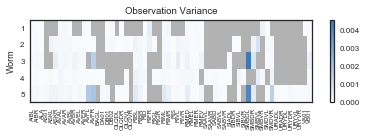

In [152]:
# Look at the observation variance across worms
sigma_obs = hrslds.emission_distns[0].sigmasq_flat.copy()
sigma_obs_mask = np.array([np.any(~m[:,:D_obs], axis=0) for m in data_masks])
sigma_obs[sigma_obs_mask] = np.nan

masked_sigma_obs = np.ma.array(sigma_obs, mask=sigma_obs_mask)

cmap = gradient_cmap([np.ones(3), colors[0]])
cmap.set_bad(0.7 * np.ones(3))

fig = plt.figure(figsize=(5.5, 2.))
ax = fig.add_subplot(111)
im = ax.imshow(sigma_obs, vmin=0, vmax=vmax, aspect="auto", cmap=cmap)
ax.set_xticks(np.arange(D_obs))
ax.set_xticklabels(all_neuron_names[:D_obs], rotation="90", fontsize=6)
ax.set_yticks(np.arange(N_worms))
ax.set_yticklabels(np.arange(N_worms) + 1)
ax.set_ylabel("Worm")

ax.set_title("Observation Variance")

plt.colorbar(im)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "observation_variance.pdf"))


cluster sizes:  [ 4 11 19 26]


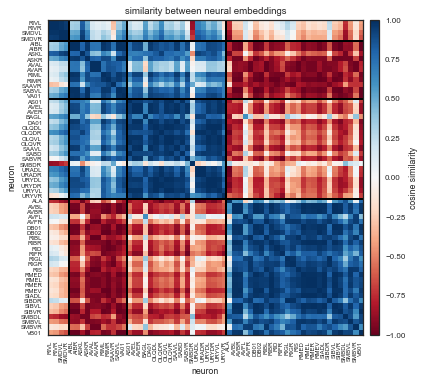

In [89]:
C_true = hrslds.emission_distns[0].A[:,:-1]
S_true = C_true.dot(C_true.T)
S_true /= np.linalg.norm(C_true, axis=1)[:, None]
S_true /= np.linalg.norm(C_true, axis=1)[None, :]

# @cached("permute_neurons")
def permute_by_emission_similarity(N_clusters=4, seed=2):
    from sklearn.cluster import SpectralClustering
    np.random.seed(seed)
    cluster = SpectralClustering(n_clusters=N_clusters, affinity="precomputed")
    cluster.fit((1+S_true) / 2.0)
    labels = cluster.labels_

    avg_C = np.zeros((N_clusters, D_latent))
    for c in range(N_clusters):
        if not np.any(labels==c):
            continue
        avg_C[c] = np.mean(C_true[labels==c], axis=0)

    # Permute the cluster labels by doing PCA on the average C and sorting
    from sklearn.decomposition import PCA
    pca = PCA(n_components=1)
    weights = pca.fit_transform(avg_C)[:,0]
    labels_perm = np.argsort(weights)
    avg_C = avg_C[labels_perm]
    labels = relabel_by_permutation(labels, np.argsort(labels_perm))

    # Relabel one neurons
    if N_clusters == 4 and seed == 2:
        labels[4] = 1
        labels[2] = 3
    
    # Lex sort by label then by emission vector
    # perm = np.lexsort(np.row_stack((C_true.T, labels)))
    perm = np.lexsort((all_neuron_names[:D_obs], labels))
    return perm, labels[perm]

# Run the clustering
N_clusters = 4
perm, labels = permute_by_emission_similarity(N_clusters=N_clusters, seed=2)
iperm = np.argsort(perm)


# Plot the similarity matrix
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
im = ax.imshow(S_true[np.ix_(perm, perm)], cmap="RdBu", vmin=-1, vmax=1)

cluster_sizes = np.bincount(labels, minlength=N_clusters)
print("cluster sizes: ", cluster_sizes)

offsets = np.cumsum(cluster_sizes) - 1
for o in offsets[:-1]:
    ax.plot([o+.5, o+.5], [-0.5, D_obs+0.5], '-', lw=2, color=0 * np.ones(3))
    ax.plot([-.5, D_obs+0.5], [o+.5, o+.5], '-', lw=2, color=0 * np.ones(3))
plt.xlim(-0.5, D_obs-0.5)
plt.ylim(D_obs-0.5, -0.5)
plt.xlabel("neuron")
plt.ylabel("neuron")
plt.xticks(np.arange(D_obs), all_neuron_names[perm], rotation=90, fontsize=6)
plt.yticks(np.arange(D_obs), all_neuron_names[perm], fontsize=6)
plt.title("similarity between neural embeddings")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)    
plt.colorbar(mappable=im, cax=cax, label="cosine similarity")

plt.tight_layout()

plt.savefig(os.path.join(results_dir, "permuted_similarity.pdf"))
plt.savefig(os.path.join(results_dir, "permuted_similarity.png"), dpi=300)

In [91]:
offset = 0
for c in range(N_clusters):
    print("Cluster ", c)
    cluster_names = []
    for n in range(offset, D_obs):
        if labels[n] > c:
            offset = n
            break
        cluster_names.append(all_neuron_names[perm[n]])

#     print([name for name in sorted(cluster_names)])
    print(cluster_names) 
    print("")

Cluster  0
['RIVL', 'RIVR', 'SMDVL', 'SMDVR']

Cluster  1
['AIBL', 'AIBR', 'ASKL', 'ASKR', 'AVAL', 'AVAR', 'RIML', 'RIMR', 'SAAVR', 'SABVL', 'VA01']

Cluster  2
['AS01', 'AVEL', 'AVER', 'BAGL', 'DA01', 'OLQDL', 'OLQDR', 'OLQVL', 'OLQVR', 'SAAVL', 'SABD', 'SABVR', 'SMBDR', 'URADL', 'URADR', 'URYDL', 'URYDR', 'URYVL', 'URYVR']

Cluster  3
['ALA', 'AVBL', 'AVBR', 'AVFL', 'AVFR', 'DB01', 'DB02', 'RIBL', 'RIBR', 'RID', 'RIFR', 'RIGL', 'RIGR', 'RIS', 'RMED', 'RMEL', 'RMER', 'RMEV', 'SIADL', 'SIBDR', 'SIBVL', 'SIBVR', 'SMBDL', 'SMBVL', 'SMBVR', 'VB01']



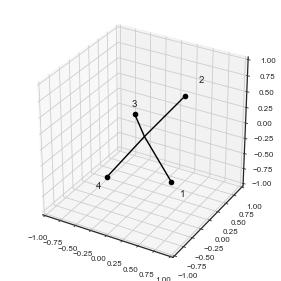

In [35]:
avg_C = np.zeros((N_clusters, D_latent))
for c in range(N_clusters):
    if not np.any(labels==c):
        continue
    avg_C[c] = np.mean(C_true[perm][labels==c], axis=0)
        
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection="3d")
avg_C_norm = avg_C / np.linalg.norm(avg_C, axis=1)[:, None]
for c in range(N_clusters):
    plt.plot([0, avg_C_norm[c, 0]],
             [0, avg_C_norm[c, 1]],
             [0, avg_C_norm[c, 2]],
             '-', color='k')
    plt.plot([avg_C_norm[c, 0]],
             [avg_C_norm[c, 1]],
             [avg_C_norm[c, 2]],
             'o', color='k')
    
    ax.text(1.3*avg_C_norm[c, 0],
            1.3*avg_C_norm[c, 1],
            1.3*avg_C_norm[c, 2],
             str(c+1))

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, "cluster_orientation.png"), dpi=300)

In [36]:
def simulate_dynamics(dd, x0, T):
    X = np.zeros((T, dd.D_out))
    X[0] = x0
    for t in range(1, T):
        xp = np.concatenate((X[t-1], [1]))
        X[t] = dd.predict(xp)
    return X

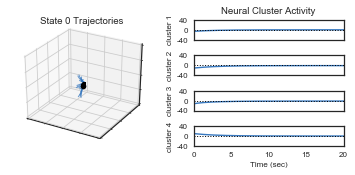

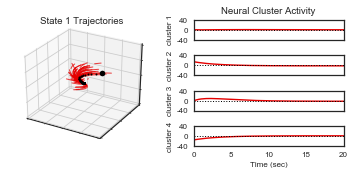

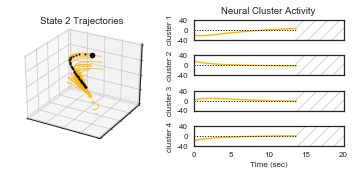

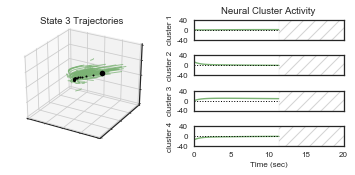

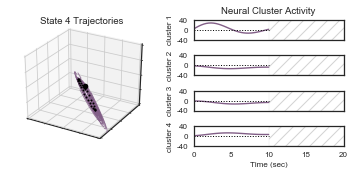

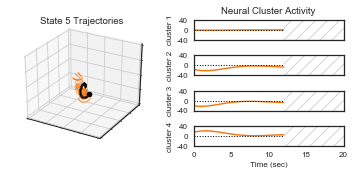

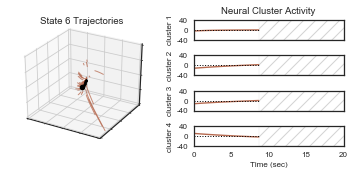

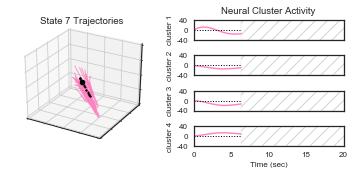

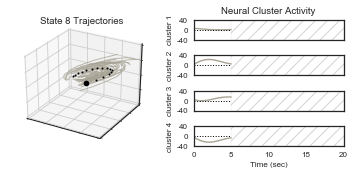

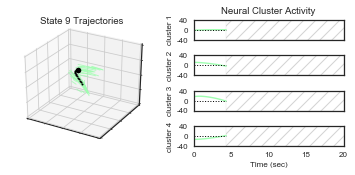

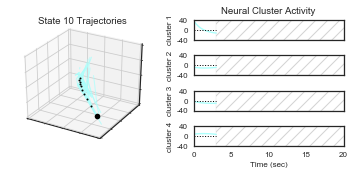

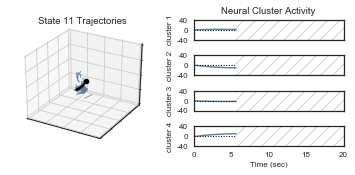

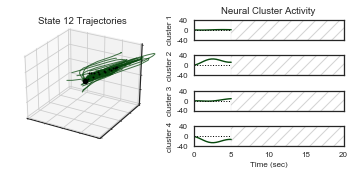

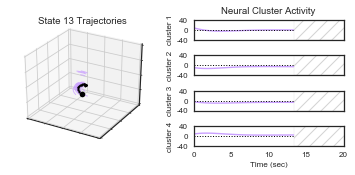

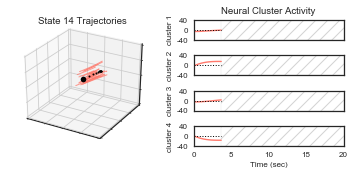

In [37]:
# Set the initial starting points for each state
# These were determined by looking at the average starting 
# point of the inferred trajectories and then manually tweaking them a bit
starts = np.array([
    [-5.0,   5.5, -10.0],
    [13.0,  12.9,  8.0],
    [-4.0,  23.0,  24.0],
    [13.0,  12.9,  8.0],
    [ 2.2,  -3.0, -4.1],
    [ 1.0,   7.5, -21.2],
    [-5.0,   4.0, -11.0],
    [-1.6,  -2.0, -0.5],
    [ 5.0,  -5.0,  1.6],
    [-2.8,  -6.4,  18.2],
    [26.0,  -20.0, -28.0],
    [1.3,    0.8,  0.6],
    [ 0.8,   0.9,  0.1],
    [ 2.2,  -7.2, -12.4],
    [-4.1,   5.0,  0.0]])

from pyhsmm.util.general import rle
hrslds_z_finals_rle = [rle(z) for z in hrslds_z_finals]

sns.set_context('paper')
X_sims = []
for k in range(Kmax):
    # Find longest trajectory
    Tmax = -np.inf
    for worm in range(N_worms):
        for z, dur in zip(*hrslds_z_finals_rle[worm]):
            if z == k and dur > Tmax:
                Tmax = dur

    # Find and plot the partial trajectories of this state
    fig = plt.figure(figsize=(5,2.5))
    gs = gridspec.GridSpec(N_clusters, 2, width_ratios=[1.0, 1.0])
    ax = fig.add_subplot(gs[:,0], projection="3d")
    ax.set_title("State {} Trajectories".format(k))
    
    for worm in range(N_worms):
        X = hrslds_x_finals[worm]
        offset = 0
        for z, dur in zip(*hrslds_z_finals_rle[worm]):
            if z == k:
                plt.plot(X[offset:offset+dur, 0],
                         X[offset:offset+dur, 1],
                         X[offset:offset+dur, 2],
                         '-k', lw=1.0, color=colors[k],
                         alpha=0.75)
                
            offset += dur

    # Simulate a canonical trajectory
    X_sim = simulate_dynamics(hrslds_dynamics_distns[k], starts[k], Tmax)
    X_sims.append(X_sim)
    plt.plot(X_sim[:1,0], X_sim[:1, 1], X_sim[:1,2], 'o', color='k')
    plt.plot(X_sim[:,0], X_sim[:, 1], X_sim[:,2], '.', markersize=4, color='k', lw=1)
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.set_zlim(-40, 40)
    ax.set_xticks([-40, -20, 0, 20, 40])
    ax.set_yticks([-40, -20, 0, 20, 40])
    ax.set_zticks([-40, -20, 0, 20, 40])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # Plot the neural activity
    t_sim = np.arange(Tmax) / 3.0
    Y_sim = X_sim.dot(avg_C_norm.T)
    for c in range(N_clusters):
        axc = fig.add_subplot(gs[c,1])
        axc.plot(t_sim, Y_sim[:,c], '-', color=colors[k])
        axc.plot(t_sim, np.zeros_like(t_sim), ':k', lw=1)
        if c == 0:
            axc.set_title("Neural Cluster Activity")
                
        axc.set_ylabel("cluster {}".format(c+1), fontsize=8)
        axc.set_ylim(-40, 40)
        axc.set_yticks([-40, 0, 40])
        axc.set_yticklabels([-40, 0, 40], fontsize=8)
        
        if c == N_clusters - 1:
            axc.set_xlabel("Time (sec)", fontsize=8)
            axc.set_xticks([0, 5, 10, 15, 20])
            axc.set_xticklabels([0, 5, 10, 15, 20], fontsize=8)
        else:
            axc.set_xticks([])
        axc.set_xlim(0, 20)
        from matplotlib.patches import Rectangle
        if t_sim[-1] < 20:
            axc.add_patch(Rectangle((t_sim[-1], -40), 20-t_sim[-1], 80, 
                                    edgecolor='lightgray', 
                                    fill=False, hatch='//'))
        
    plt.tight_layout(pad=1.0)
    plt.savefig(os.path.join(results_dir, "canonical_cluster_activity_{}.pdf".format(k)))
    plt.savefig(os.path.join(results_dir, "canonical_cluster_activity_{}.png".format(k)), dpi=300)
    
    


#  Align trajectories 

In [38]:
# def align_trajectories(Xs):
#     # Xs is a list of trajectories of variable length
#     # Ys is the output: an aligned set of trajectories
#     assert isinstance(Xs, list)
#     N = len(Xs)
#     D = Xs[0].shape[1]
#     assert np.all([X.shape[1] == D for X in Xs])
    
#     Ts = np.array([X.shape[0] for X in Xs])
#     perm = np.argsort(Ts)[::-1]
#     Tmax = Ts.max()
    
#     max_inds = np.zeros((3*Tmax,), dtype=bool)
#     max_inds[Tmax:2*Tmax] = True
    
#     # Initialize the output with the longest trajectory first
#     Y = np.nan * np.ones((N, 3*Tmax, D))
#     Y[0,Tmax:2*Tmax] = Xs[perm[0]]
#     for i in progprint_xrange(1,N):
#         n = perm[i]
#         Xn, Tn = Xs[n], Ts[n]
#         minoverlap = min(Tmax//2, Tn)
#         start = Tmax-Tn+minoverlap
#         stop = Tmax+Tn-minoverlap
#         scores = -np.inf * np.ones(3*Tmax)
#         for offset in range(start, stop+1):
#             inds = np.zeros(3 * Tmax, dtype=bool)
#             inds[offset:offset+Tn] = True
#             overlap = np.sum(inds * max_inds)
            
#             Xne = np.nan * np.ones((3*Tmax, D))
#             Xne[offset:offset+Tn] = Xn
            
#             # Score is negative of average distance between Y and X
#             sqerr = -0.5 * np.nanmean((Y[:i] - Xne)**2) 
#             scores[offset] = sqerr * overlap * D
            
#             # Upweight longer overlaps
#             scores[offset] += overlap
                
#         best_offset = np.argmax(scores)
#         Y[i, best_offset:best_offset+Tn] = Xn
        
#     return Y
    

In [39]:
# # Test alignment code
# N = 10
# Tmax = 20
# ts = np.linspace(0, 2*2*np.pi, 2*Tmax)
# sines = np.sin(ts) + 0.1 * np.random.randn(N, 2*Tmax)
# offsets = np.random.randint(Tmax//2, Tmax, size=N)
# lengths = np.random.randint(Tmax//3, Tmax, size=N)
# Xs = [s[o:o+l][:,None] for s,o,l in zip(sines, offsets, lengths)]

# plt.figure()
# for X in Xs:
#     plt.plot(X)
    
# # Now align them
# Ys = align_trajectories(Xs)

# plt.figure()
# for Y in Ys:
#     plt.plot(Y)

In [40]:
# min_dur = 5
# max_dur = 100

# for k in range(Kmax):

#     # Find the median midpoint of the trajectories
#     Xks = []
#     for worm in range(N_worms):
#         X = hrslds_x_finals[worm]
#         offset = 0
#         for z, dur in zip(*hrslds_z_finals_rle[worm]):
#             if z == k and dur >= min_dur and dur < max_dur: 
#                 Xks.append(X[offset:offset+dur])
#             offset += dur

#     # Align the trajectories
#     Yks = align_trajectories(Xks)
#     Tk = Yks.shape[1] / 3.
            
#     # Plot the trajectories aligned to the time when they are closest to the midpoint 
#     fig = plt.figure(figsize=(10,6))
#     axx = fig.add_subplot(311)
#     axy = fig.add_subplot(312)
#     axz = fig.add_subplot(313)

#     axx.plot(Yks[0,:,0], lw=1, color=colors[k])
#     axy.plot(Yks[0,:,1], lw=1, color=colors[k])
#     axz.plot(Yks[0,:,2], lw=1, color=colors[k])

#     for Y in Yks[1:]:
#         axx.plot(Y[:,0], lw=0.5, color=colors[k])
#         axy.plot(Y[:,1], lw=0.5, color=colors[k])
#         axz.plot(Y[:,2], lw=0.5, color=colors[k])

#     # Plot the mean
#     Ymean = np.nanmean(Yks, axis=0)
#     axx.plot(Ymean[:,0], lw=2, color='k')
#     axy.plot(Ymean[:,1], lw=2, color='k')
#     axz.plot(Ymean[:,2], lw=2, color='k')

        
#     for ax in [axx, axy, axz]:
#         ax.plot([Tk, Tk], [-40, 40], ':k')
#         ax.plot([2*Tk, 2*Tk], [-40, 40], ':k')

In [41]:
# min_dur = 5
# max_dur = 100

# for k in range(Kmax):
#     dd = hrslds.dynamics_distns[k]
    
#     # Find the median midpoint of the trajectories
#     Xks = []
#     for worm in range(N_worms):
#         X = hrslds_x_finals[worm]
#         offset = 0
#         for z, dur in zip(*hrslds_z_finals_rle[worm]):
#             if z == k and dur >= min_dur and dur < max_dur: 
#                 Xks.append(X[offset:offset+dur])
#             offset += dur

#     from sklearn.cluster import KMeans
#     N_clusters = 15
#     km = KMeans(N_clusters)
#     km.fit(np.vstack(Xks))
#     centers = km.cluster_centers_
    
#     # Connect the centers based on probability under the dynamics distn
#     lps = np.zeros((N_clusters, N_clusters))
#     for c in range(N_clusters):
#         xc = np.concatenate((centers[c], [1]))[None,:]
#         lps[c] = dd.log_likelihood((np.tile(xc, (N_clusters, 1)), centers))
#     np.fill_diagonal(lps, -np.inf)
        
#     # Find the most likely successor of each center
#     G = np.zeros((N_clusters, N_clusters))
#     for c in range(N_clusters):
#         G[c, np.argmax(lps[c])] = 1
            
#     # Plot the trajectories aligned to the time when they are closest to the midpoint 
#     fig = plt.figure(figsize=(10,6))
#     ax = fig.add_subplot(111, projection="3d")
#     ax.plot(centers[:,0],
#             centers[:,1],
#             centers[:,2],
#             'o', color=colors[k])
    
#     for c1 in range(N_clusters):
#         for c2 in range(N_clusters):
#             if c1 == c2 or not G[c1, c2]:
#                 continue
#             ax.plot([centers[c1,0], centers[c2, 0]],
#                     [centers[c1,1], centers[c2, 1]],
#                     [centers[c1,2], centers[c2, 2]],
#                     '-', color=colors[k])
    
#     ax.set_xlim(-40,40)
#     ax.set_ylim(-40,40)
#     ax.set_zlim(-40,40)